In [1]:
import pandas as pd
import geopandas as gpd
import requests
import json
from shapely.geometry import Polygon
from matplotlib import pyplot as plt
import folium
from h3 import h3
from tqdm import tqdm
%matplotlib inline

import numpy as np

In [2]:
def get_county_block_geoms(state_fips, county_fips):
    base_url = (
        'https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/'
        'Tracts_Blocks/MapServer/12/query?where=STATE%3D{0}+and+COUNTY%3D{1}'
        '&outFields=GEOID%2CSTATE%2CCOUNTY%2CTRACT%2CBLKGRP%2CBLOCK%2CCENTLAT'
        '%2CCENTLON&outSR=%7B"wkid"+%3A+4326%7D&f=pjson')
    url = base_url.format(state_fips, county_fips)
    result = requests.get(url)
    features = result.json()['features']
    df = pd.DataFrame()
    for feature in tqdm(features, total=len(features), desc='block geoms for county {0}'.format(county_fips)):
        tmp = pd.DataFrame([feature['attributes']])
        tmp['geometry'] = Polygon(feature['geometry']['rings'][0], feature['geometry']['rings'][1:])
        df = pd.concat((df, tmp))
    gdf = gpd.GeoDataFrame(df, crs="EPSG:4326")
    return gdf

In [3]:
def get_block_geoms(blocks):
    all_block_geoms = []
    for county in county_codes:
        county_gdf = get_county_block_geoms(state_fips, county)
        all_block_geoms.append(county_gdf)
    all_blocks_gdf = gpd.GeoDataFrame(pd.concat(all_block_geoms), crs="EPSG:4326")
    return all_blocks_gdf

In [7]:
def get_zone_geoms_from_h3(h3_ids):
    polygon_shapes = []
    for zone in h3_ids:
        boundary_points = h3.h3_to_geo_boundary(h3_address=zone, geo_json=True)
        shape = Polygon(boundary_points)
        polygon_shapes.append(shape)

    return polygon_shapes

In [53]:
blocks = pd.read_hdf('data/model_data.h5', 'blocks')

In [6]:
county_codes = blocks.index.str.slice(2, 5).unique()

In [7]:
state_fips = 48

In [20]:
%%time
blocks_gdf = get_block_geoms(blocks)

block geoms for county 491: 100%|██████████| 9081/9081 [00:30<00:00, 300.30it/s]


CPU times: user 2min 32s, sys: 2.79 s, total: 2min 34s
Wall time: 6min 35s


In [21]:
blocks_gdf.to_file('austin_block_geoms.shp')

In [28]:
blocks_gdf = gpd.read_file('austin_block_geoms.shp')

In [3]:
skims = pd.read_csv(
    'https://beam-outputs.s3.amazonaws.com/output/austin/austin-prod-200k-skims-with-h3-index-final__2020-04-18_09-44-24_wga/ITERS/it.0/0.skimsOD.UrbanSim.Full.csv.gz')

In [4]:
h3_zone_ids = skims.origTaz.unique()

In [8]:
zone_geoms = get_zone_geoms_from_h3(h3_zone_ids)

In [9]:
zones = gpd.GeoDataFrame(
    h3_zone_ids, geometry=zone_geoms, crs="EPSG:4326")
zones.columns = ['h3_id', 'geometry']
zones['area'] = zones.geometry.area
zones['TAZ'] = list(range(1, len(h3_zone_ids) + 1))
zones['h3_res'] = zones['h3_id'].apply(h3.h3_get_resolution)

zones = zones.set_index('TAZ')

(29.5, 31.1)

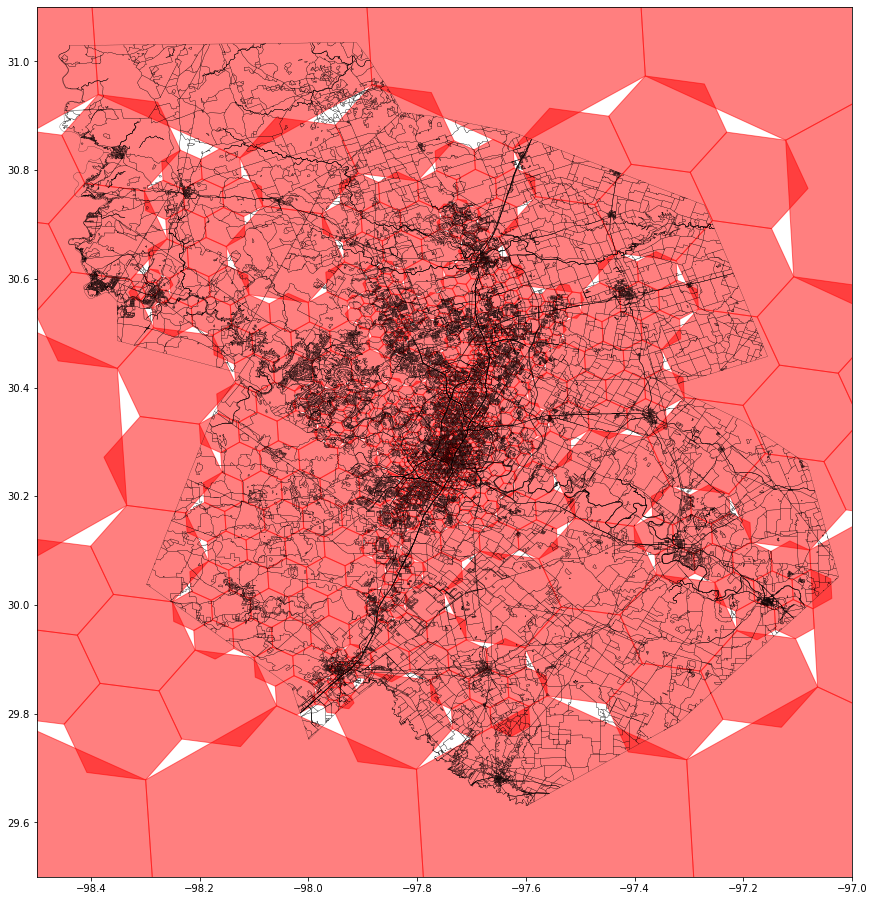

In [175]:
fig, ax = plt.subplots(figsize=(16,16))
zones.plot(facecolor='r', edgecolor='r', alpha=0.5, ax=ax)
blocks_gdf.plot(facecolor='none', edgecolor='k', linewidth=0.2, ax=ax)
ax.set_xlim(-98.5,-97)
ax.set_ylim(29.5,31.1)

In [29]:
%%time
intx = gpd.overlay(blocks_gdf, zones.reset_index(), how='intersection')

CPU times: user 17 s, sys: 82 ms, total: 17 s
Wall time: 17 s


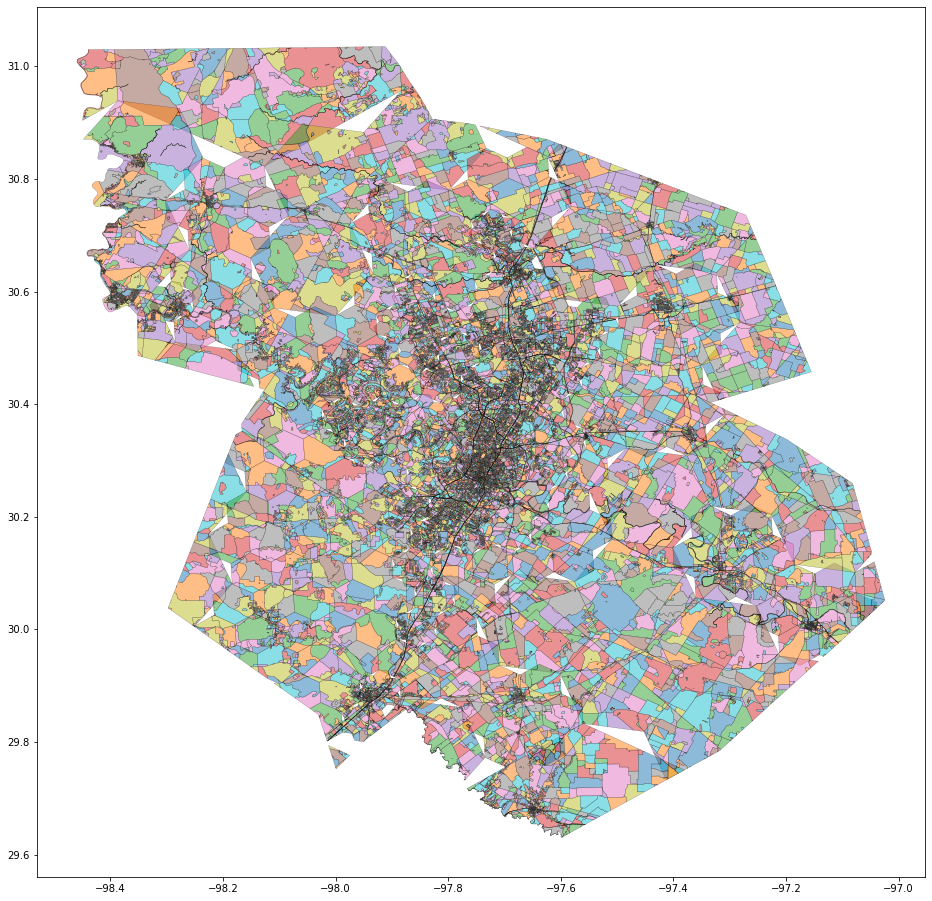

In [15]:
intx['rand'] = np.random.choice(intx.index, len(intx), replace=False)
fig, ax = plt.subplots(figsize=(16,16))
intx.plot(ax=ax, cmap='tab10', column='rand', alpha=0.5, edgecolor='k', linewidth=0.3)

In [30]:
intx = intx.to_crs('EPSG:2768')
intx['intx_area'] = intx['geometry'].area
intx = intx.sort_values(['GEOID', 'intx_area'], ascending=False)

In [31]:
intx = intx.drop_duplicates('GEOID', keep='first')

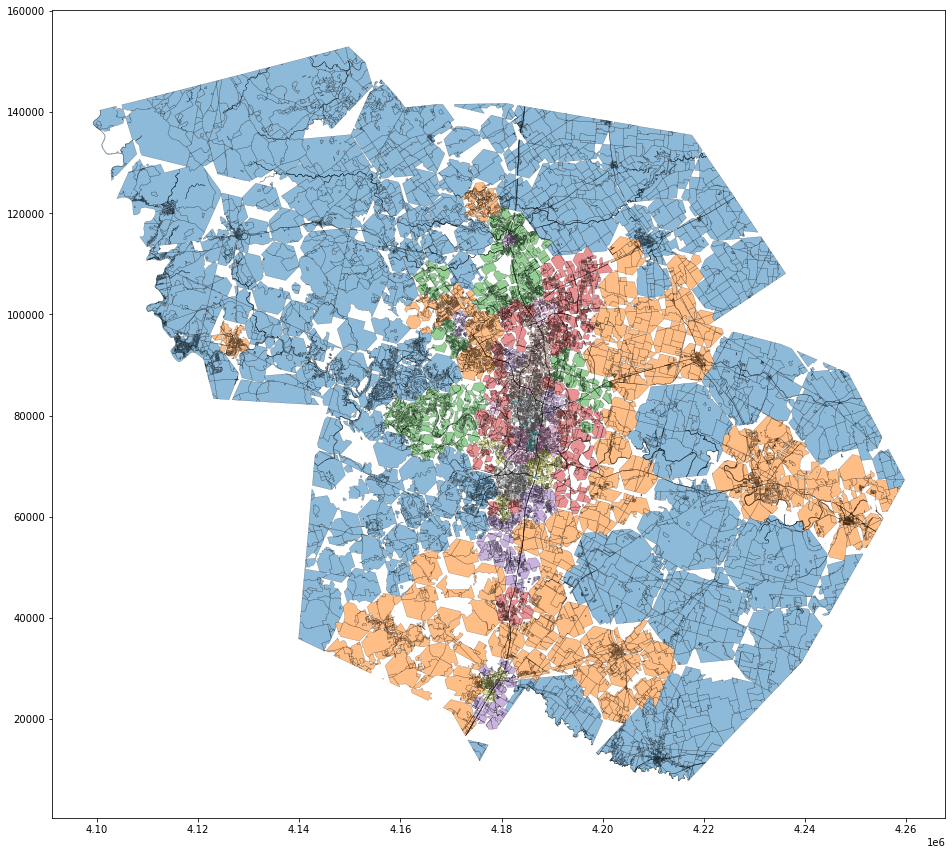

In [18]:
fig, ax = plt.subplots(figsize=(16,16))
intx.plot(ax=ax, cmap='tab10', column='h3_id', alpha=0.5, edgecolor='k', linewidth=0.3)

In [32]:
blocks_gdf = blocks_gdf.set_index('GEOID')

blocks_gdf['TAZ'] = intx.set_index('GEOID').reindex(blocks_gdf.index)['TAZ']

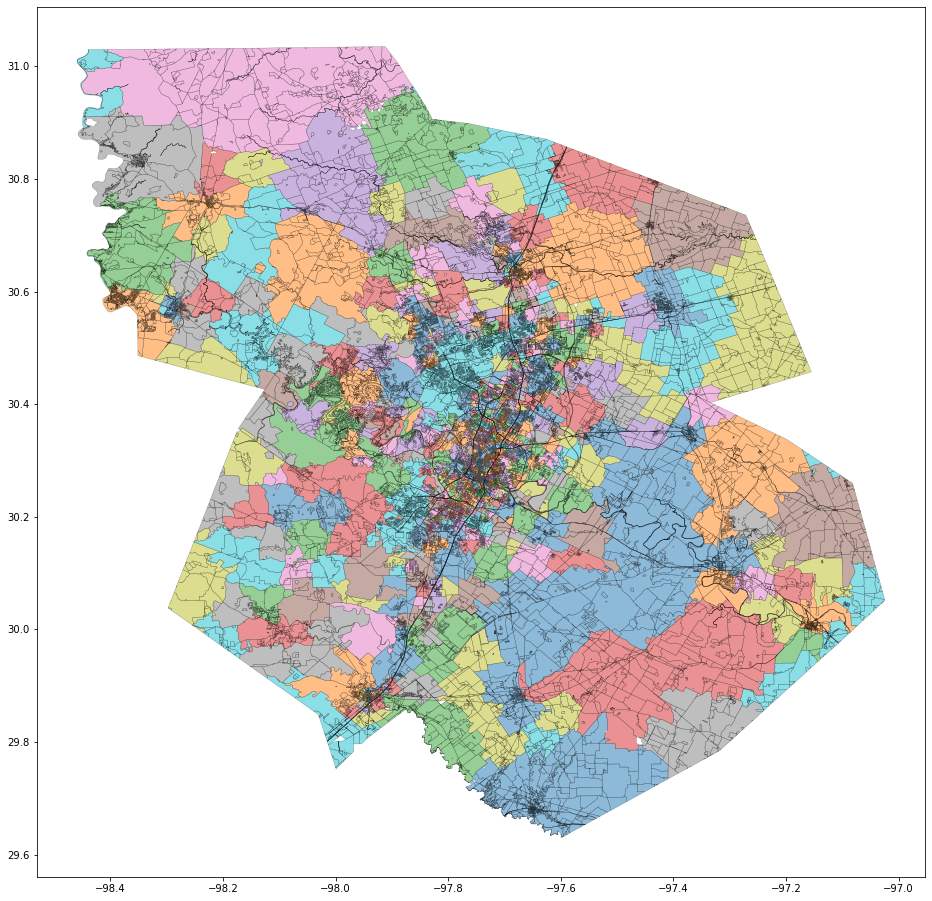

In [38]:
fig, ax = plt.subplots(figsize=(16,16))
blocks_gdf.plot(ax=ax, cmap='tab10', column='TAZ', alpha=0.5, edgecolor='k', linewidth=0.3)

(30.59033899993937, 31.196895000369082)

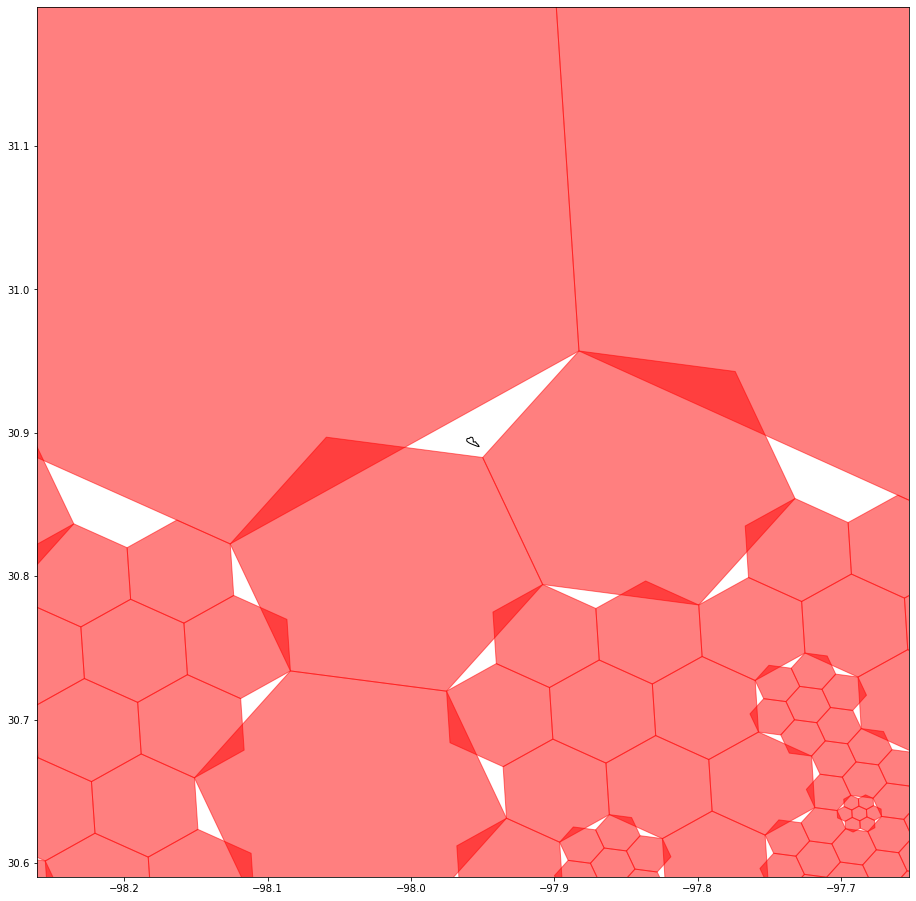

In [180]:
fig, ax = plt.subplots(figsize=(16,16))
zones.plot(facecolor='r', edgecolor='r', alpha=0.5, ax=ax)
# block = blocks_gdf[pd.isnull(blocks_gdf['h3_id'])].sample(1)
xmin, ymin, xmax, ymax = block.geometry.bounds.values[0]
block.plot(facecolor='none', edgecolor='k', linewidth=1, ax=ax)
buff = 0.3
ax.set_xlim(xmin - buff, xmax + buff)
ax.set_ylim(ymin - buff, ymax + buff)

In [57]:
any(unassigned_mask)

True

In [41]:
unassigned_mask = pd.isnull(blocks_gdf['TAZ'])

blocks_gdf['polygon_geoms'] = blocks_gdf['geometry']
blocks_gdf['geometry'] = blocks_gdf['geometry'].centroid

zones['polygon_geoms'] = zones['geometry']
zones['geometry'] = zones['geometry'].centroid

zones['zone_rand'] = zones.sample(len(zones), replace=False).index.values

zones = zones.to_crs('EPSG:2768')

blocks_gdf = blocks_gdf.to_crs('EPSG:2768')

In [50]:
%%time
all_dists = blocks_gdf.loc[unassigned_mask, 'geometry'].apply(lambda x: zones['geometry'].distance(x))

CPU times: user 2.03 s, sys: 0 ns, total: 2.03 s
Wall time: 2.03 s


In [51]:
all_dists

TAZ                      1             2             3             4     \
GEOID                                                                     
480219505021155  54397.050071  55667.046196  46458.714041  74049.385462   
480219506002043  69793.757446  72090.688894  62520.383504  90646.418683   
480219505012013  48986.655290  40113.820870  39121.407684  61754.348545   
480219506001002  74169.976467  66009.722530  64918.798822  88489.004921   
480219501002007  42360.455412  25077.892429  31916.299208  48449.185959   
...                       ...           ...           ...           ...   
484910208031068  55560.573877  24179.136888  49810.677707  33581.435833   
484910208033012  55441.384178  24168.922257  49738.811598  33348.761054   
484910205102004  37287.731226  13863.675523  33131.709821  15694.733607   
484910208052018  50416.735185  16625.579482  43214.597960  34041.147509   
484910202031031  63310.566663  35391.546296  59140.501060  36845.639584   

TAZ                      5             6             7             8     \
GEOID                                                                     
480219505021155  51655.808531  19783.876227  54285.883051  65192.427873   
480219506002043  66309.984600  34942.159421  70928.029127  79396.580886   
480219505012013  48662.249726  22241.286398  40929.630796  46709.794119   
480219506001002  72623.886005  41571.551128  67611.423983  65975.562082   
480219501002007  44248.762059  28496.330979  27617.384116  32848.166284   
...                       ...           ...           ...           ...   
484910208031068  61839.232873  67157.345287  31416.788608  21178.364584   
484910208033012  61734.655651  67198.379200  31347.760567  21462.535838   
484910205102004  43899.843127  55316.830348  15903.234430  32639.207657   
484910208052018  56111.819443  57714.468432  25250.383104  14462.188251   
484910202031031  70009.460860  78921.311794  41174.598380  32602.891445   

TAZ                      9             10    ...           994   \
GEOID                                        ...                  
480219505021155  76899.128199  45000.578264  ...  227938.364099   
480219506002043  93536.703778  52941.060483  ...  241854.598854   
480219505012013  62857.393767  53796.748553  ...  223019.904535   
480219506001002  89184.714223  68150.856307  ...  248574.932479   
480219501002007  48339.531495  58737.747167  ...  213309.562261   
...                       ...           ...  ...            ...   
484910208031068  25095.141062  89963.835142  ...  194528.574351   
484910208033012  24837.939077  89919.711118  ...  194229.578927   
484910205102004  10234.163792  73786.910001  ...  182093.005656   
484910208052018  27509.162976  82273.805285  ...  199553.409581   
484910202031031  27415.942159  99773.065501  ...  188476.167199   

TAZ                       995            996            997            998   \
GEOID                                                                         
480219505021155  217913.828507  182777.593798  151735.286974  109271.821230   
480219506002043  233094.325231  191827.739049  163688.886495  119109.714804   
480219505012013  199902.942388  185994.352400  150984.582139  112455.230999   
480219506001002  219812.048082  205998.323551  174121.681634  132436.972915   
480219501002007  184675.566078  182841.609428  144902.054625  110205.027871   
...                        ...            ...            ...            ...   
484910208031068  141319.838512  185570.508375  140789.917805  119818.644657   
484910208033012  141243.617579  185326.162260  140526.408012  119619.180660   
484910205102004  153814.713836  167428.165485  123606.114921  100792.872050   
484910208052018  151440.375848  185315.220541  141897.097332  117375.767086   
484910202031031  129216.743791  186135.946124  139942.261658  123453.008228   

TAZ                       999            1000           1001           1002  \
GEOID                                                                

In [45]:
zones.loc[all_dists.idxmin(axis=1).values]

h3_id                        geometry      area  h3_res  \
TAZ                                                                      
611  86489e0f7ffffff   POINT (4237298.571 64549.823)  0.003845       6   
928  86489e0b7ffffff   POINT (4254153.974 56905.892)  0.003838       6   
197  86489e0cfffffff   POINT (4227086.086 74143.555)  0.003849       6   
888  86489e09fffffff   POINT (4250577.752 68442.639)  0.003840       6   
28   86489e2b7ffffff   POINT (4218416.402 90472.666)  0.003854       6   
..               ...                             ...       ...     ...   
130  87489859effffff  POINT (4183573.821 116221.277)  0.000553       7   
130  87489859effffff  POINT (4183573.821 116221.277)  0.000553       7   
954  87489e259ffffff  POINT (4180760.755 100154.346)  0.000553       7   
807  87489e2caffffff  POINT (4193486.019 109235.583)  0.000552       7   
671  8748984a3ffffff  POINT (4175783.870 124719.184)  0.000553       7   

                                         polygon_geoms  zone_rand  
TAZ                                                                
611  POLYGON ((-97.25234 30.04146, -97.21785 30.060...        203  
928  POLYGON ((-97.10389 29.93804, -97.06944 29.957...         84  
197  POLYGON ((-97.32996 30.14707, -97.29544 30.166...        337  
888  POLYGON ((-97.11017 30.04592, -97.07569 30.064...        309  
28   POLYGON ((-97.37538 30.30773, -97.34081 30.326...        512  
..                                                 ...        ...  
130  POLYGON ((-97.65628 30.63039, -97.64670 30.641...        565  
130  POLYGON ((-97.65628 30.63039, -97.64670 30.641...        565  
954  POLYGON ((-97.72463 30.49687, -97.71506 30.507...        242  
807  POLYGON ((-97.57425 30.54823, -97.56468 30.558...        549  
671  POLYGON ((-97.71334 30.72108, -97.70376 30.731...        691  

[182 rows x 6 columns]

In [54]:
blocks

x          y  res_rents  res_values  \
block_id                                                       
480219501003014 -97.429419  30.213914      525.0     92500.0   
480219501003015 -97.432013  30.220892      525.0    116700.0   
480219503005030 -97.360855  30.105624      940.0    132300.0   
480219502004004 -97.365360  30.345393      350.0     74900.0   
480219505021143 -97.214820  30.072865      820.0    162500.0   
...                    ...        ...        ...         ...   
484910216032048 -97.621948  30.834507      742.0    133100.0   
484910216013025 -97.613080  30.804771      534.0    195600.0   
484910202044012 -97.894266  30.818098      680.0    141300.0   
484910203123004 -97.864223  30.568745      985.0    109800.0   
484910207041005 -97.656878  30.512350      837.0    132100.0   

                 square_meters_land puma10_id  residential_unit_capacity  \
block_id                                                                   
480219501003014             7234430   4805100                       6257   
480219501003015                2623   4805100                          2   
480219503005030              205922   4805100                        178   
480219502004004               27387   4805100                         24   
480219505021143             1124252   4805100                        972   
...                             ...       ...                        ...   
484910216032048               20784   4805201                         15   
484910216013025               16709   4805201                         14   
484910202044012                6100   4805201                          5   
484910203123004               46836   4805204                         41   
484910207041005              102346   4805202                         89   

                 employment_capacity  rent_impute  value_impute place_id  \
block_id                                                                   
480219501003014                 3575            0             0            
480219501003015                    1            1             1            
480219503005030                  102            0             0  4805864   
480219502004004                   14            0             0  4823044   
480219505021143                  556            0             0            
...                              ...          ...           ...      ...   
484910216032048                   15            0             0  4837396   
484910216013025                    4            1             1  4837396   
484910202044012                    5            0             0            
484910203123004                   12            0             0  4842016   
484910207041005                   25            0             0  4863500   

                        taz_id  zone_id  proportion_undevelopable  
block_id                                                           
480219501003014  4802100001389     1389                  0.068985  
480219501003015  4802100001389     1389                  0.000000  
480219503005030  4802100001171     2192                  0.095609  
480219502004004  4802100001214     1214                  0.000000  
480219505021143  4802100001157     1157                  0.294069  
...                        ...      ...                       ...  
484910216032048  4849100000877     2392                  0.000000  
484910216013025  4849100001701     1023                  0.000000  
484910202044012  4849100000945      945                  0.000000  
484910203123004  4849100000854      854                  0.000000  
484910207041005  4849100001400     1400                  0.207331  

[37569 rows x 14 columns]

In [55]:
blocks_gdf.loc[unassigned_mask, 'TAZ'] = all_dists.idxmin(axis=1).values

In [56]:
blocks_gdf

STATE COUNTY   TRACT BLKGRP BLOCK      CENTLAT       CENTLON  \
GEOID                                                                          
480219506001084    48    021  950600      1  1084  +30.0393427  -097.0931829   
480219506001141    48    021  950600      1  1141  +30.0428106  -097.0873637   
480219506001115    48    021  950600      1  1115  +30.0276596  -097.0690887   
480219506001167    48    021  950600      1  1167  +30.0125109  -097.1237613   
480219506001118    48    021  950600      1  1118  +30.0372304  -097.0423764   
...               ...    ...     ...    ...   ...          ...           ...   
484910208082060    48    491  020808      2  2060  +30.5566513  -097.4756427   
484910205032008    48    491  020503      2  2008  +30.4936161  -097.7002043   
484910205032007    48    491  020503      2  2007  +30.4936822  -097.6991133   
484910205032010    48    491  020503      2  2010  +30.4908957  -097.6993972   
484910205032012    48    491  020503      2  2012  +30.4930614  -097.6974510   

                                       geometry    TAZ  \
GEOID                                                    
480219506001084   POINT (4253553.236 64293.771)  920.0   
480219506001141   POINT (4254005.764 64809.620)  920.0   
480219506001115   POINT (4256148.005 63608.581)  920.0   
480219506001167   POINT (4251412.444 60650.619)  121.0   
480219506001118   POINT (4258400.601 65289.683)  920.0   
...                                         ...    ...   
484910208082060  POINT (4203402.407 111231.398)  481.0   
484910205032008   POINT (4184039.782 99135.804)  955.0   
484910205032007   POINT (4184140.432 99168.427)  955.0   
484910205032010   POINT (4184188.876 98859.694)  955.0   
484910205032012   POINT (4184313.235 99139.914)  955.0   

                                                     polygon_geoms  
GEOID                                                               
480219506001084  POLYGON ((-97.09837 30.04070, -97.09833 30.040...  
480219506001141  POLYGON ((-97.08845 30.04293, -97.08843 30.042...  
480219506001115  POLYGON ((-97.07088 30.02841, -97.07076 30.028...  
480219506001167  POLYGON ((-97.12438 30.01243, -97.12391 30.012...  
480219506001118  POLYGON ((-97.04430 30.03793, -97.04428 30.038...  
...                                                            ...  
484910208082060  POLYGON ((-97.47803 30.55775, -97.47437 30.558...  
484910205032008  POLYGON ((-97.70106 30.49513, -97.70105 30.495...  
484910205032007  POLYGON ((-97.70011 30.49569, -97.70006 30.495...  
484910205032010  POLYGON ((-97.70023 30.49174, -97.69997 30.491...  
484910205032012  POLYGON ((-97.69860 30.49378, -97.69859 30.493...  

[37569 rows x 10 columns]

In [277]:
blocks_gdf = pd.merge(blocks_gdf, zones[['h3_id', 'zone_rand']].reset_index(), on='h3_id')

In [278]:
blocks_gdf['geometry'] = blocks_gdf['polygon_geoms']

In [279]:
zones['geometry'] = zones['polygon_geoms']

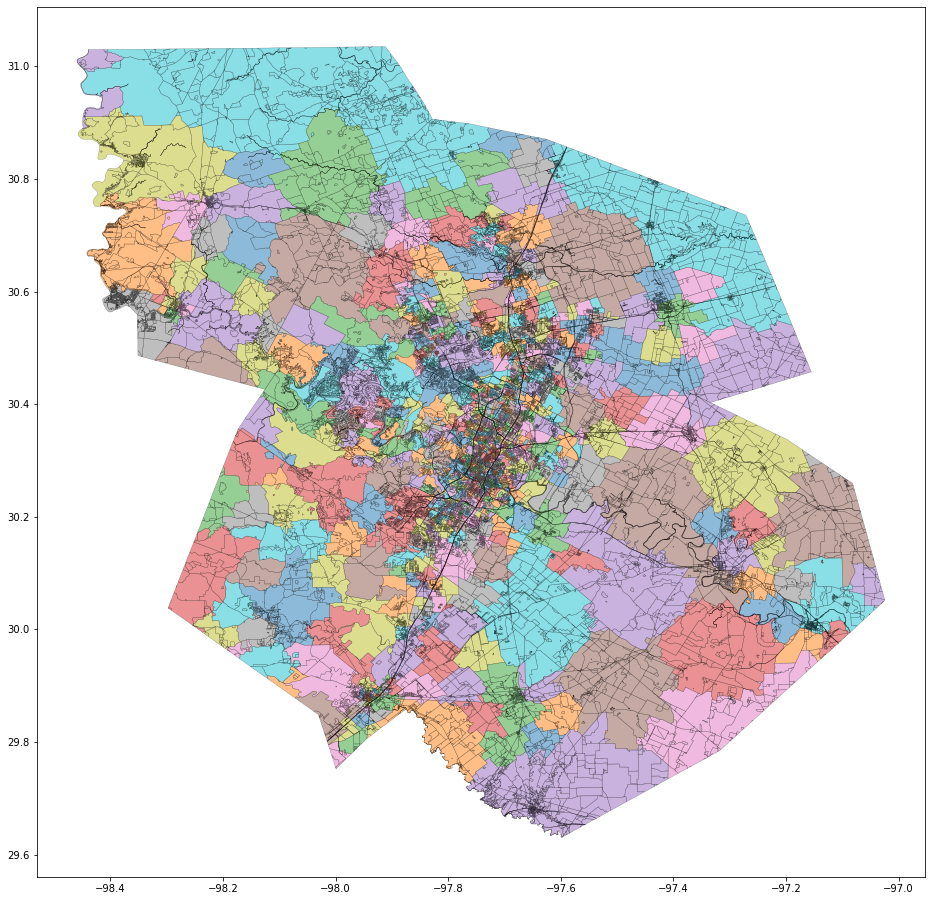

In [280]:
fig, ax = plt.subplots(figsize=(16,16))
ax = blocks_gdf.plot(edgecolor='k', linewidth=0.3, alpha=0.5, cmap='tab10', column='zone_rand', categorical=True, ax=ax)

(29.560503450296146, 31.105223550322563)

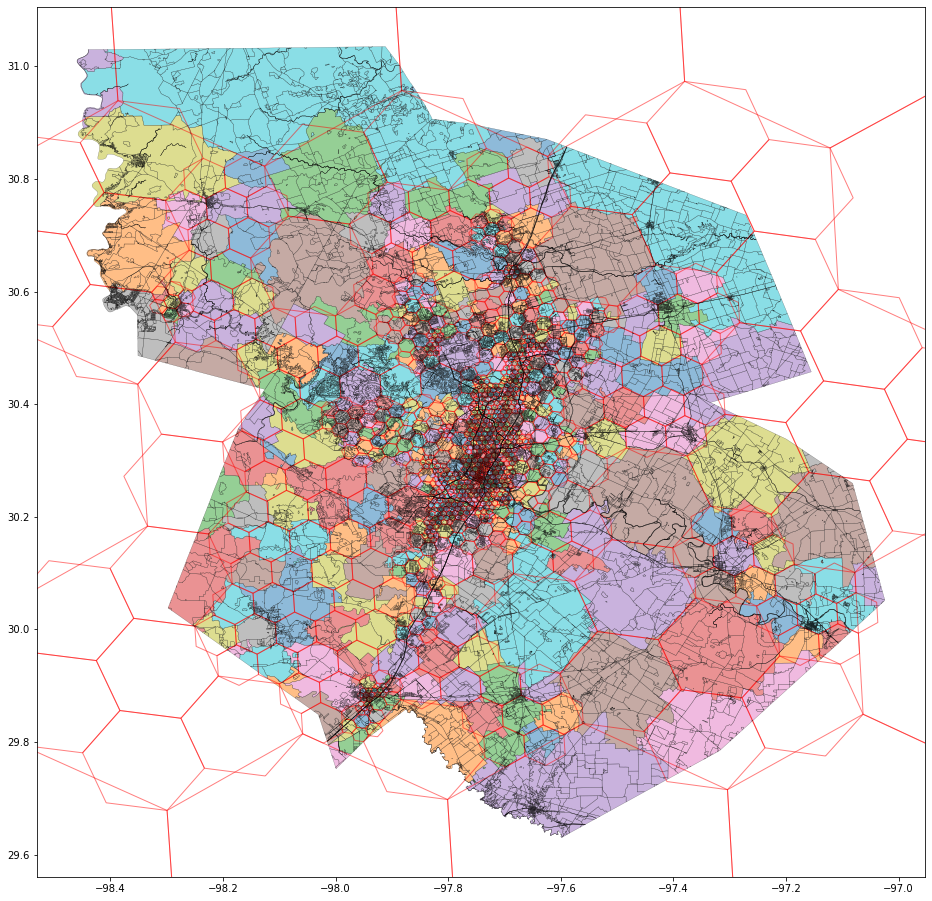

In [281]:
fig, ax = plt.subplots(figsize=(16,16))
blocks_gdf.plot(edgecolor='none', alpha=0.5, cmap='tab10', column='zone_rand', categorical=True, ax=ax)
xmin, xmax, ymin, ymax = ax.axis()
zones.plot(facecolor='none', edgecolor='r', alpha=0.5, ax=ax)
blocks_gdf.plot(edgecolor='k', linewidth=0.3, alpha=0.5, facecolor='none', ax=ax)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

In [283]:
blocks_gdf[.dtypes]

GEOID              object
STATE              object
COUNTY             object
TRACT              object
BLKGRP             object
BLOCK              object
CENTLAT            object
CENTLON            object
geometry         geometry
h3_id              object
polygon_geoms    geometry
TAZ                 int64
zone_rand           int64
dtype: object

In [284]:
blocks_gdf[[col for col in blocks_gdf.columns if col != 'polygon_geoms']].to_file('blocks_assigned.shp')